# Imports

In [1]:
import numpy as np
import pandas as pd
import os
import re, math
from IPython.core.display import display

In [2]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph
import warnings
from sklearn import metrics
from sklearn.manifold import TSNE   # t-SNE – algorithm to downsize of matrix

from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import category_encoders as ce
from tqdm.notebook import tqdm

In [3]:
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 15, 10         # make default plot size
%config InlineBackend.figure_format = 'svg' # make default plot format svg
%matplotlib inline
import seaborn as sns

# Constants

In [4]:
SEED=42
np.random.seed(SEED)
TARGET = 'price'

# Load Data

In [5]:
# ---- Path for Kaggle ---
# PATH = '../input/sf-dst-car-price-prediction-part2/'
# ---- Path for local ----
PATH=''

data = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')
sample_submission = pd.read_csv(PATH + 'sample_submission.csv')
pd.set_option('display.max_columns', None)

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

# Functions
**for distribution analyse**

In [130]:
def vector_items(vector: str):
    """
    function to show filling difference between same vectors in train and test datasets
    :param vector: name of vector
    :return: difference between train and test, test and train and unique values of test
    """
    train_set = set(data[vector])
    test_set = set(test[vector])
    train_dif = train_set - test_set
    test_dif = test_set - train_set
    print(f'------ Test_set in vector "{vector}" has values: -------')
    print(test_set)
    print(f'------Statistics:  ---------------------------')
    print(f'Data-set has {len(train_set)} unique items and has difference:\n{train_dif},')
    print('--')
    print(f'Test-set has {len(test_set)} unique items and has difference:\n{test_dif}.')

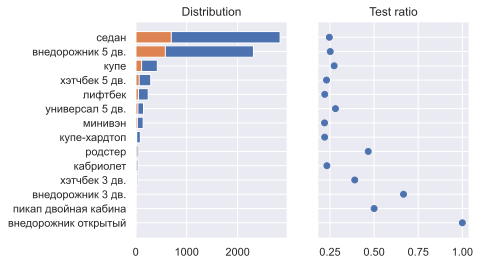

------ Test_set in vector "bodyType" has values: -------
{'минивэн', 'лифтбек', 'хэтчбек 5 дв.', 'внедорожник открытый', 'хэтчбек 3 дв.', 'внедорожник 5 дв.', 'внедорожник 3 дв.', 'родстер', 'кабриолет', 'купе', 'пикап двойная кабина', 'купе-хардтоп', 'седан', 'универсал 5 дв.'}
------Statistics:  ---------------------------
Data-set has 14 unique items and has difference:
set(),
--
Test-set has 14 unique items and has difference:
set().


In [131]:
def cat_distribution(vector: str):
    """
    function shows distribution in given categorical vectors and ratio between test and data sets
    :param vector: name of vector
    :return: show charts and vector_items statistic
    """
    val_data = data[vector].value_counts()
    val_data = pd.DataFrame(data=val_data.values, index=val_data.index, columns=['data'])
    val_test = test[vector].value_counts()
    val_test = pd.DataFrame(data=val_test.values, index=val_test.index, columns=['test'])
    val = val_data.join(val_test, how='outer').sort_values(by='data', ascending=True)
    val['portion'] = val.test/val.data

    fig, axs = plt.subplots(1, 2, sharey=True)
    axs[0].barh(val.index, val.data)
    axs[0].barh(val.index, val.test)
    axs[0].set_title('Distribution')
    axs[1].scatter(val.portion, val.index)
    axs[1].set_title('Test ratio')
    plt.show()

    vector_items(vector)

cat_distribution('bodyType')

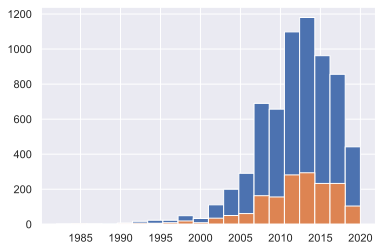

------ Test_set in vector "productionDate" has values: -------
{1982, 1984, 1985, 1986, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020}
------Statistics:  ---------------------------
Data-set has 36 unique items and has difference:
{1988, 1983},
--
Test-set has 35 unique items and has difference:
{1991}.


In [135]:
def num_distributions(vector: str):
    """
    function shows distribution in given numerical vectors
    :param vector:
    :return:
    """
    val_data = data[vector].dropna()
    val_test = test[vector].dropna()
    plt.hist(val_data, bins=20)
    plt.hist(val_test, bins=20)
    plt.show()

    vector_items(vector)
num_distributions('productionDate')

# Functions
**for ML analyse**

In [11]:
def mape(y_true, y_pred):
    """
    function to calculate Mean Absolute Percentage Error
    """
    return np.mean(np.abs((y_pred-y_true)/y_true))*100

In [144]:
results = pd.DataFrame()
def feature_imp(dataset, regressor, encoder, test_drop = True, target='price'):
    """
    function for checking feature importance on ML
    :param dataset: dataset for ML
    :param regressor: algorithm of ML
    :param encoder: encoder for categorical vectors
    :param test_drop: boolean flag whether need to separate test data from dataset
    :param target: name of target
    :return: list of features with weights descending, score of algorithm and MAPE score
    """
    global results

    # copy dataset useful if you need to drop some vectors from dataset
    dataset=dataset.copy()

    # checkin boolean flag to drop test data from dataset
    if test_drop:
        dataset = dataset[dataset.test == 0]

    # drop vector 'test'
    # dataset.drop(['test'], axis=1, inplace=True)

    # make variables x and y for ML model
    x, y = dataset.drop(target, axis=1), np.log(dataset[target])

    # encoding categorical vectors with encoder
    encoder.fit(x, y)
    X = encoder.transform(x)

    # split for validate and fit ML model
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=SEED)
    regressor.fit(X_train, y_train)

    # make dataframe with features importance
    importance = regressor.feature_importances_
    value = pd.DataFrame(data=importance, index=X.columns, columns=['importance'])
    print(value.importance.sort_values(ascending=False))

    # calculate ML model score
    score = regressor.score(X_test, y_test)
    print(f'Score of regressor {score*100:0.2f}%')

    # calculate MAPE score
    predict = np.exp(regressor.predict(X_test))
    print(f"MAPE: {(mape(np.exp(y_test), predict)):0.2f}%")

    if not results.empty:
        results.drop(columns=results.columns, inplace=True)
    results = X_test.copy()
    results['y_test'] = np.exp(y_test)
    results['predict'] = predict.astype('int64')

# Functions
**for EDA**

In [ ]:
def find_number(field: str):
    """
    function to take only first numeric data from string
    :param field: string to find number
    :return: number (in string format)
    """

    # mask for search
    p = '[\d]+[.,\d]+|[\d]*[.][\d]+|[\d]+'

    # main cycle for searching
    if re.search(p, field) is not None:
        for catch in re.finditer(p, field):
            return catch[0]

In [ ]:
def corr_tab(data=data, target=TARGET):
    """
    function to calculate correlation table
    :param data: dataset for analyse
    :param target: target vector in dataset
    :return: dataset of correlation values ascending from most to less
    """
    num_list = list(data.drop(target, axis=1).select_dtypes(include=['int64', 'float64']).columns)
    num_list.append(target)
    print(num_list)
    return data[num_list].corr()[target].abs().sort_values(ascending=False)

In [ ]:
def name_separate(item):
    """
    function to separete text value in vector 'name' and return only first part
    :param item: text value from field of vector
    :return: first part of text value like '180 BlueEFFICIENCY 1.8 AT'
    """
    result = item.replace('(','-').replace(')','-').split('-')
    if len(result)==3:
        third = result[2]
    else:
        third = ''

    return result[0]#, result[1], third

In [148]:
def list_cut(to_cut):
    """
    function to reshape list to dataframe with several columns instead of one
    :param to_cut: list for processing
    :return: show result
    """
    # call function to separate list on baches and generate column headers for dataframe
    to_cut = list(np.sort(to_cut))
    cut_list = lambda item: [item[i:i+7] for i in range(0, len(item), 7)]
    name_list = lambda nom: ["vectors"+ str(i) for i in range(0,math.ceil(nom/7))]

    # create dataframe with data
    df_ = pd.DataFrame(cut_list(to_cut)).T
    df_.columns = name_list(len(to_cut))
    df_.fillna('', inplace=True)

    # show
    display(df_)

In [ ]:
def heatmap(drop_list, dd=data, target = TARGET):
    """
    Visualise correlation by heatmap draw
    :param drop_list: list to drop from analyse
    :param dd: dataset to analyse
    :param target: target vector
    :return: show heatmap plot and list of droped columns
    """
    dlst = list(set(dd.columns) - set(drop_list) - {target})
    dlst = list(np.sort(dlst))

    dlst.append(target)
    sns.set(font_scale=1)
    plt.subplots(figsize=(16, 16))
    sns.heatmap(dd[dlst].corr(), square=True,
                annot=True, fmt=".3f", linewidths=0.1, cmap="RdBu", vmin=-1, vmax=1)

    list_cut(drop_list)

# Naive ML-model

In [ ]:
list_to_drop = [] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)

In [ ]:
# Some results ot testing
# -----------------------
# CatBoostRegressor 12.50%
# ExtraTreesRegressor 12.78%
# LGBMRegressor 12.99%
# XGBRegressor 13.79%
# RandomForestRegressor 13.04%

### Resume:
best result shown by CatBoostRegressor, but ExtraTreesRegressor also not so bad.

# Analyse datasets
Check data in data-set in test-set for distribution values in vectors and to find values in data-set which don't present in test-set

In [ ]:
ejection=dict()

In [ ]:
ejection['Руль']= {'Правый'}

#### Resume:
- so distribution of data values is the same in data and test sets with ratio near 25%
- final dict of values which is not present in test shown in def cooking()

# EDA

### bodyType  &  numberOfDoors

In [ ]:
vector = 'bodyType'
vector_items(vector)

In [148]:
ejection={
    'color': {'розовый'},
    'engineDisplacement': {'3.4 LTR', '4.6 LTR', '4.9 LTR', '5.6 LTR', '6.3 LTR'},
    'sell_id': {1100083262},
    'Руль': {'Правый'},
    'bodyType': {'седан 2 дв.', 'компактвэн', 'лимузин'}
 }
ejection

{'color': {'розовый'},
 'engineDisplacement': {'3.4 LTR', '4.6 LTR', '4.9 LTR', '5.6 LTR', '6.3 LTR'},
 'sell_id': {1100083262},
 'Руль': {'Правый'},
 'bodyType': {'компактвэн', 'лимузин', 'седан 2 дв.'}}

In [ ]:
vector_items('numberOfDoors')

---
Выяснилось, что есть записи, где очевидно ошибочно указано количество дверей в поле "numberOfDoors" для "bodyType" 'хэтчбек 3 дв. - как 2. Исправим это. Кроме этого, запомнил еще несколько кандидатов на включение в "шум" двнных

In [ ]:
train_set = set(data['bodyType'])
for item in train_set:
    n_doors_list = list(data.loc[(data.bodyType == item),'numberOfDoors'].value_counts().index)
    print(f'"{item}" have {n_doors_list} doors')

In [ ]:
data.loc[(data.bodyType == 'хэтчбек 3 дв.') & (data.numberOfDoors == 2),'numberOfDoors']=3

In [ ]:
n_doors = {
 'внедорожник 3 дв.': 'внедорожник',
 'внедорожник 5 дв.': 'внедорожник',
 'внедорожник открытый': 'внедорожник открытый',
 'кабриолет': 'кабриолет',
 'компактвэн': 'компактвэн',
 'купе': 'купе',
 'купе-хардтоп': "купе-хардтоп",
 'лимузин': 'лимузин',
 'лифтбек': 'лифтбек',
 'минивэн': 'минивэн',
 'пикап двойная кабина': 'пикап двойная кабина',
 'родстер': 'родстер',
 'седан': 'седан',
 'седан 2 дв.': 'седан',
 'универсал 5 дв.': 'универсал',
 'хэтчбек 3 дв.': 'хэтчбек',
 'хэтчбек 5 дв.': 'хэтчбек'
}

In [ ]:
data['body'] = data.bodyType.map(n_doors)
test['body'] = test.bodyType.map(n_doors)

In [ ]:
data['bodyDoors'] = data.apply(lambda q: str(q.body)+" "+str(q.numberOfDoors),axis=1)
test['bodyDoors'] = test.apply(lambda q: str(q.body)+" "+str(q.numberOfDoors),axis=1)

In [ ]:
# Mini-Max normalization do not increase MAPE

#scaler = MinMaxScaler()
#data['numberOfDoorsMM'] = scaler.fit_transform(data[['numberOfDoors']])

In [ ]:
#data.drop('numberOfDoorsMM', axis=1, inplace=True)

In [ ]:
list_to_drop = ['bodyType'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% - Nive
# 12.22% - EDA body, bodyDoors (exclude bodyType)

## brand
- nothing to do with
## color
- classification on costs didn't improve mape

In [ ]:
vector='color'
data.info()

In [ ]:
data.groupby(['color']).agg({'sell_id': ['count'], 'price': ['mean']}).astype('int32').sort_values(by=[(  'price',  'mean')], ascending=False)

In [ ]:
color_type = {
    'розовый': "rare",
    'жёлтый': "rare",
    'оранжевый': "rare",
    'чёрный': "casual",
    'серый': "casual",
    'синий': "casual",
    'белый': "casual",
    'зелёный': "cheap",
    'голубой': "cheap",
    'коричневый': "cheap",
    'фиолетовый': "cheap",
    'красный': "cheap",
    'серебристый': "cheap",
    'золотистый': "cheap",
    'бежевый': "cheap",
    'пурпурный': "cheap"
}

In [ ]:
data['color_type'] = data.color.map(color_type)
test['color_type'] = test.color.map(color_type)

In [ ]:
list_to_drop = ['color_type'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% Naive
# 12.34% FE body and doors

## engineDisplacement
numeric value from 'engineDisplacement' make better mape

In [ ]:
vector='engineDisplacement'
data.info()

In [ ]:
vector_items(vector)

In [ ]:
data['engineDisplacementValue']=data.engineDisplacement.apply(find_number)
test['engineDisplacementValue']=test.engineDisplacement.apply(find_number)
data.engineDisplacementValue.fillna(value=0.0001, inplace=True)
test.engineDisplacementValue.fillna(value=0.0001, inplace=True)

In [ ]:
data.engineDisplacementValue=data.engineDisplacementValue.apply(float)
test.engineDisplacementValue=test.engineDisplacementValue.apply(float)

In [ ]:
scaler = MinMaxScaler()
data['edvMinMax']=scaler.fit_transform(data[['engineDisplacementValue']])

In [ ]:
test['edvMinMax']=scaler.transform(test[['engineDisplacementValue']])

In [ ]:
list_to_drop = ['bodyType', 'engineDisplacement'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% - Nive
# 12.22% - EDA body, bodyDoors (exclude bodyType)
# 12.11% - EDA engineDisplacementValue-float, edv-MinMax (exclude engineDisplacement)


## enginePower
FE:
- numeric value from ‘enginePower’
- log function on valeu

make better mape

In [ ]:
vector='enginePower'
data.info()

In [ ]:
vector_items(vector)

In [ ]:
data['enginePowerValue']=data.enginePower.apply(find_number).apply(int)
test['enginePowerValue']=test.enginePower.apply(find_number).apply(int)

In [ ]:
data['epvLog'] = data.enginePowerValue.apply(np.log)
test['epvLog'] = test.enginePowerValue.apply(np.log)

In [ ]:
# Min-Max scaling do not increase MAPE

#data.drop('epvMinMax', axis=1, inplace=True)
#scaler = MinMaxScaler()
#data['epvMinMax'] = scaler.fit_transform(data[['enginePowerValue']])

In [ ]:
#test['epvMinMax'] = scaler.transform(test[['enginePowerValue']])

## fuelType

All efforts had no luck to increase MAPE

In [ ]:
vector='fuelType'
data.info()

In [ ]:
vector_items(vector)

In [ ]:
# FE # combine fuel type and value of displacement
data['fuel_displacement']=data.apply(lambda q: q.fuelType + ' ' + str(q.engineDisplacementValue), axis=1)

In [ ]:
list_to_drop = ['engineDisplacement', 'enginePower', 'fuelType'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% Naive
# 12.34% FE body and doors
# 12.29% EDA engineDisplacementValue (exclude engineDisplacement)
# 11.69% EDA enginePowerValue (exclude enginePower)

In [ ]:
# FE # make vector of fuel costs
fuel_cost={
    'бензин': 3.9,
    'дизель': 3.8,
    'гибрид': 2.5,
    'электро': 0.29
}

In [ ]:
data['fuel_cost']=data.fuelType.map(fuel_cost)

In [ ]:
num_list = list(data.drop(TARGET, axis=1).select_dtypes(include=['int64', 'float64']).columns)
num_list.append(TARGET)
num_list
data[num_list].corr()[TARGET].abs().sort_values(ascending=False)

In [ ]:
list_to_drop = ['engineDisplacement', 'enginePower'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% Naive
# 12.34% FE body and doors
# 12.29% EDA engineDisplacementValue (exclude engineDisplacement)
# 11.69% EDA enginePowerValue (exclude enginePower)

# mileage
All efforts had no luck to increase MAP

In [ ]:
vector='mileage'
data.info()

In [ ]:
data['mileageYear']=data.apply(lambda q: q.mileage / (2021 - q.productionDate), axis=1)

In [31]:
data['mileageLog']=data.mileage.apply(np.log)

In [33]:
data.drop('mileage', axis=1, inplace=True)

In [ ]:
# scaler do not increase MAPE

#scaler = MinMaxScaler()
#data['mileageMM']=scaler.fit_transform(data[['mileage']])

In [ ]:
#scaler = MinMaxScaler()
#data['mileageYearMM']=scaler.fit_transform(data[['mileageYear']])

In [ ]:
#data.drop(['mileageYearMM'], axis=1, inplace=True)

In [ ]:
list_to_drop = ['bodyType', 'engineDisplacement', 'enginePower'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% - Nive
# 12.22% - EDA body, bodyDoors (exclude bodyType)
# 12.11% - EDA engineDisplacementValue-float, edv-MinMax (exclude engineDisplacement)
# 11.85% - EDA enginePowerValue (exclude enginePower)

# name
FE:
 - taking only first part of fields
 - making new vector with more precise name of vehicle
make MAPE a little bit better

In [ ]:
vector='name'
data.info()

In [ ]:
data['name1'] = data.name.apply(name_separate)
data.vehicle = data.brand + ' ' + data.model_info + ' ' + data.vehicleConfiguration + ' ' + data.name1

test['name1'] = test.name.apply(name_separate)
test.vehicle = test.brand + ' ' + test.model_info + ' ' + test.vehicleConfiguration + ' ' + data.name1

# modelDate
using MinMax scale to vector improve MAPE

In [ ]:
vector = 'modelDate'
data.info()

In [ ]:
corr_tab()

In [ ]:
vector_items(vector)

In [29]:
data['modelDateLog']=data.modelDate.apply(lambda q: np.log(2022-q))

In [ ]:
scaler=MinMaxScaler()
data['modelDateMM']=scaler.fit_transform(data[['modelDate']])

In [ ]:
test['modelDateMM']=scaler.transform(test[['modelDate']])

In [ ]:
list_to_drop = ['bodyType', 'engineDisplacement', 'enginePower', 'modelDate'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% - Nive
# 12.22% - EDA body, bodyDoors (exclude bodyType)
# 12.11% - EDA engineDisplacementValue-float, edv-MinMax (exclude engineDisplacement)
# 11.85% - EDA enginePowerValue (exclude enginePower)
# 11.80% - EDA modelDate-MinMax (exclude modelDate)

# model_info, numberOfDoors
- nothing to do


In [ ]:
data.info()

In [ ]:
vector='numberOfDoors'

In [ ]:
# scaler fail to increase MAPE

#scaler=MinMaxScaler()
#data['doorsMM']=scaler.fit_transform(data[['numberOfDoors']])

In [ ]:
#data.drop('doorsMM', axis=1, inplace=True)

In [ ]:
list_to_drop = ['bodyType', 'engineDisplacement', 'enginePower', 'modelDate'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% - Nive
# 12.22% - EDA body, bodyDoors (exclude bodyType)
# 12.11% - EDA engineDisplacementValue-float, edv-MinMax (exclude engineDisplacement)
# 11.85% - EDA enginePowerValue (exclude enginePower)
# 11.80% - EDA modelDate-MinMax (exclude modelDate)

# productionDate
Using MinMax scale and log function were fail to improve MAPE

In [ ]:
data.info()

In [ ]:
#scaler=MinMaxScaler()
#data['productionDateMM']=scaler.fit_transform(data[['productionDate']])

In [ ]:
#data.drop('productionDateMM', axis=1, inplace=True)

In [27]:
data['productionDateLog']=data.productionDate.apply(lambda q: np.log(2022-q))

In [ ]:
list_to_drop = ['bodyType', 'engineDisplacement', 'enginePower', 'modelDate'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% - Nive
# 12.22% - EDA body, bodyDoors (exclude bodyType)
# 12.11% - EDA engineDisplacementValue-float, edv-MinMax (exclude engineDisplacement)
# 11.85% - EDA enginePowerValue (exclude enginePower)
# 11.80% - EDA modelDate-MinMax (exclude modelDate)

# vehicleConfiguration, vehicleTransmission
after all I just drop vector 'vehicleTransmission'...

In [ ]:
data.info()
vector='vehicleTransmission'

In [ ]:
vector_items(vector)

In [67]:
list_to_drop = [#'bodyType',
                #'engineDisplacement',
                #'enginePower',
                #'modelDate',
                #'vehicleTransmission'
                ] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% - Nive
# 12.22% - EDA body, bodyDoors (exclude bodyType)
# 12.11% - EDA engineDisplacementValue-float, edv-MinMax (exclude engineDisplacement)
# 11.85% - EDA enginePowerValue (exclude enginePower)
# 11.80% - EDA modelDate-MinMax (exclude modelDate)
# 11.77% - just exclude vehicleTransmission

Learning rate set to 0.052599
0:	learn: 0.7204883	total: 17ms	remaining: 17s
1:	learn: 0.6923386	total: 24.2ms	remaining: 12.1s
2:	learn: 0.6645945	total: 30.1ms	remaining: 10s
3:	learn: 0.6385630	total: 44.2ms	remaining: 11s
4:	learn: 0.6136996	total: 56ms	remaining: 11.1s
5:	learn: 0.5907573	total: 144ms	remaining: 23.8s
6:	learn: 0.5679392	total: 149ms	remaining: 21.2s
7:	learn: 0.5469210	total: 154ms	remaining: 19.1s
8:	learn: 0.5271542	total: 160ms	remaining: 17.6s
9:	learn: 0.5084563	total: 166ms	remaining: 16.4s
10:	learn: 0.4921812	total: 169ms	remaining: 15.2s
11:	learn: 0.4750489	total: 172ms	remaining: 14.2s
12:	learn: 0.4592387	total: 176ms	remaining: 13.4s
13:	learn: 0.4443162	total: 184ms	remaining: 12.9s
14:	learn: 0.4296680	total: 189ms	remaining: 12.4s
15:	learn: 0.4156488	total: 194ms	remaining: 11.9s
16:	learn: 0.4027048	total: 197ms	remaining: 11.4s
17:	learn: 0.3902183	total: 202ms	remaining: 11s
18:	learn: 0.3791675	total: 207ms	remaining: 10.7s
19:	learn: 0.36839

# Владельцы, Владение
EDA:
- fill n/a

FE:
- extract quantity of owners as text and as number
- extract years of ownership

In [ ]:
data.info()

In [113]:
data['Владельцы'].fillna('2 владельца', inplace=True)  # fill n/a with value

In [114]:
data['owners']=data['Владельцы'].apply(find_number)
data.owners.value_counts()

3    2646
1    2029
2    2007
Name: owners, dtype: int64

In [117]:
data['ownerValue'] = data.apply(lambda q: int(q.owners), axis=1)

In [120]:
list_to_drop = [#'bodyType',
    #'engineDisplacement',
    #'enginePower',
    #'modelDate',
    #'vehicleTransmission'
    #'Владельцы'
] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 11,78

Learning rate set to 0.052599
0:	learn: 0.7205167	total: 2.82ms	remaining: 2.82s
1:	learn: 0.6913732	total: 5.34ms	remaining: 2.67s
2:	learn: 0.6636176	total: 7.74ms	remaining: 2.57s
3:	learn: 0.6381436	total: 10.1ms	remaining: 2.52s
4:	learn: 0.6126316	total: 16.3ms	remaining: 3.25s
5:	learn: 0.5893908	total: 37.9ms	remaining: 6.28s
6:	learn: 0.5673930	total: 43.6ms	remaining: 6.19s
7:	learn: 0.5462094	total: 49ms	remaining: 6.08s
8:	learn: 0.5277530	total: 54.1ms	remaining: 5.96s
9:	learn: 0.5086598	total: 59.1ms	remaining: 5.85s
10:	learn: 0.4914552	total: 63.9ms	remaining: 5.75s
11:	learn: 0.4744145	total: 69.1ms	remaining: 5.69s
12:	learn: 0.4582100	total: 74ms	remaining: 5.62s
13:	learn: 0.4434779	total: 79.9ms	remaining: 5.63s
14:	learn: 0.4300286	total: 85.5ms	remaining: 5.61s
15:	learn: 0.4159953	total: 100ms	remaining: 6.15s
16:	learn: 0.4031736	total: 105ms	remaining: 6.07s
17:	learn: 0.3905376	total: 110ms	remaining: 5.99s
18:	learn: 0.3792509	total: 115ms	remaining: 5.92s


In [84]:
data['Владение'].unique()

array([nan, '8 лет и 6 месяцев', '4 года и 9 месяцев',
       '2 года и 9 месяцев', '6 лет и 9 месяцев', '4 года и 3 месяца',
       '5 лет и 7 месяцев', '1 год и 2 месяца', '3 года',
       '4 года и 10 месяцев', '1 год и 3 месяца', '6 лет и 8 месяцев',
       '2 года', '7 месяцев', '1 месяц', '1 год и 8 месяцев',
       '1 год и 9 месяцев', '2 года и 2 месяца', '6 лет и 7 месяцев',
       '6 лет и 2 месяца', '2 года и 5 месяцев', '8 лет и 3 месяца',
       '2 года и 10 месяцев', '2 года и 3 месяца', '3 года и 1 месяц',
       '5 лет и 9 месяцев', '8 лет и 2 месяца', '6 лет и 6 месяцев',
       '14 лет и 3 месяца', '2 года и 4 месяца', '5 лет и 1 месяц',
       '11 лет и 3 месяца', '10 месяцев', '3 года и 2 месяца',
       '7 лет и 11 месяцев', '5 лет и 4 месяца', '3 года и 5 месяцев',
       '10 лет и 2 месяца', '4 года и 6 месяцев', '5 лет и 11 месяцев',
       '2 года и 6 месяцев', '4 года и 8 месяцев', '6 лет и 4 месяца',
       '1 год и 10 месяцев', '1 год и 5 месяцев', '2 года и

In [121]:
data['Владение'].fillna('Не известно', inplace=True)
data['ownerYears']=data['Владение'].apply(find_number)

In [125]:
data.ownerYears.fillna('0', inplace=True)

In [126]:
data.ownerYears = data.apply(lambda q: int(q.ownerYears), axis=1)

In [128]:
data.ownerYears = data.apply(lambda q: (2021-int(q.productionDate))/int(q.owners), axis=1)

In [133]:
list_to_drop = [#
    #'ownerYears'
] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 11,78

Learning rate set to 0.052599
0:	learn: 0.7205167	total: 8.14ms	remaining: 8.14s
1:	learn: 0.6913732	total: 13.2ms	remaining: 6.6s
2:	learn: 0.6636176	total: 17.4ms	remaining: 5.79s
3:	learn: 0.6381436	total: 23.4ms	remaining: 5.84s
4:	learn: 0.6126316	total: 29ms	remaining: 5.77s
5:	learn: 0.5893908	total: 33.9ms	remaining: 5.62s
6:	learn: 0.5673930	total: 38.6ms	remaining: 5.47s
7:	learn: 0.5462094	total: 47.1ms	remaining: 5.84s
8:	learn: 0.5277530	total: 53.2ms	remaining: 5.86s
9:	learn: 0.5086598	total: 58ms	remaining: 5.74s
10:	learn: 0.4914552	total: 63.4ms	remaining: 5.7s
11:	learn: 0.4744145	total: 70ms	remaining: 5.76s
12:	learn: 0.4582100	total: 89.7ms	remaining: 6.81s
13:	learn: 0.4434779	total: 95.3ms	remaining: 6.71s
14:	learn: 0.4300286	total: 108ms	remaining: 7.07s
15:	learn: 0.4159953	total: 111ms	remaining: 6.84s
16:	learn: 0.4031736	total: 123ms	remaining: 7.13s
17:	learn: 0.3905376	total: 138ms	remaining: 7.5s
18:	learn: 0.3792509	total: 148ms	remaining: 7.63s
19:	le

## ПТС
no luck to improve MAPE

In [136]:
data['ПТС'].value_counts()

Оригинал    5970
Дубликат     712
Name: ПТС, dtype: int64

In [137]:
data['PTS']=data['ПТС'].apply(lambda q: 1 if q=='Оригинал' else 0)

In [141]:
list_to_drop = [#
    'PTS',
] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 11,78

Learning rate set to 0.052599
0:	learn: 0.7205167	total: 2.82ms	remaining: 2.81s
1:	learn: 0.6913732	total: 5.08ms	remaining: 2.54s
2:	learn: 0.6636176	total: 7.05ms	remaining: 2.34s
3:	learn: 0.6381436	total: 9.06ms	remaining: 2.25s
4:	learn: 0.6126316	total: 11.1ms	remaining: 2.2s
5:	learn: 0.5893908	total: 13.1ms	remaining: 2.17s
6:	learn: 0.5673930	total: 15ms	remaining: 2.13s
7:	learn: 0.5462094	total: 17.2ms	remaining: 2.13s
8:	learn: 0.5277530	total: 19.2ms	remaining: 2.11s
9:	learn: 0.5086598	total: 21.4ms	remaining: 2.12s
10:	learn: 0.4914552	total: 23.4ms	remaining: 2.1s
11:	learn: 0.4744145	total: 25.4ms	remaining: 2.09s
12:	learn: 0.4582100	total: 27.7ms	remaining: 2.1s
13:	learn: 0.4434779	total: 29.6ms	remaining: 2.08s
14:	learn: 0.4300286	total: 31.6ms	remaining: 2.07s
15:	learn: 0.4159953	total: 33.5ms	remaining: 2.06s
16:	learn: 0.4031736	total: 35.6ms	remaining: 2.06s
17:	learn: 0.3905376	total: 39.5ms	remaining: 2.16s
18:	learn: 0.3792509	total: 54.3ms	remaining: 2.8

In [134]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   bodyType                 6682 non-null   object 
 1   brand                    6682 non-null   object 
 2   color                    6682 non-null   object 
 3   description              6682 non-null   object 
 4   engineDisplacement       6682 non-null   object 
 5   enginePower              6682 non-null   object 
 6   fuelType                 6682 non-null   object 
 7   mileage                  6682 non-null   int64  
 8   modelDate                6682 non-null   int64  
 9   model_info               6682 non-null   object 
 10  name                     6682 non-null   object 
 11  numberOfDoors            6682 non-null   int64  
 12  price                    6682 non-null   float64
 13  productionDate           6682 non-null   int64  
 14  sell_id                 

## Привод
nothing to do

In [149]:
vector = 'Привод'

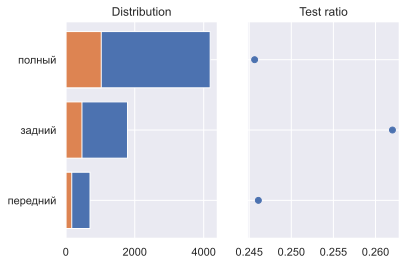

------ Test_set in vector Привод has values: -------
{'задний', 'передний', 'полный'}
------Statistics:  ---------------------------
Data has 3 unique items and has difference:
set(),
--
Test has 3 unique items and has difference:
set().


In [150]:
cat_distribution(vector)

# description
FE - make new vector of quantity words in text

# Some effort to clear data from noise
 We delete items from dataset, wich not present in test with rare feature

In [181]:
#data=data.copy()
for vector, values in ejection.items():
    for value in values:
        data = data[data[vector] != value]

In [184]:
list_to_drop = [#,
] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 11,78%
# 11,76%

Learning rate set to 0.052551
0:	learn: 0.7227875	total: 6.96ms	remaining: 6.96s
1:	learn: 0.6924780	total: 11.8ms	remaining: 5.87s
2:	learn: 0.6655110	total: 14.4ms	remaining: 4.78s
3:	learn: 0.6393736	total: 16.8ms	remaining: 4.19s
4:	learn: 0.6142103	total: 20.1ms	remaining: 3.99s
5:	learn: 0.5908613	total: 22.5ms	remaining: 3.73s
6:	learn: 0.5687235	total: 24.9ms	remaining: 3.54s
7:	learn: 0.5472674	total: 27.2ms	remaining: 3.38s
8:	learn: 0.5268610	total: 30.4ms	remaining: 3.35s
9:	learn: 0.5090234	total: 33.9ms	remaining: 3.35s
10:	learn: 0.4909468	total: 36.2ms	remaining: 3.26s
11:	learn: 0.4739531	total: 39.5ms	remaining: 3.25s
12:	learn: 0.4577444	total: 42ms	remaining: 3.19s
13:	learn: 0.4425061	total: 44.2ms	remaining: 3.11s
14:	learn: 0.4278487	total: 46.7ms	remaining: 3.06s
15:	learn: 0.4136868	total: 49ms	remaining: 3.02s
16:	learn: 0.4011601	total: 51.6ms	remaining: 2.98s
17:	learn: 0.3890052	total: 54ms	remaining: 2.95s
18:	learn: 0.3781628	total: 56.4ms	remaining: 2.91

# Cooking time! All EDA and FE in one script

In [69]:
def cooking():
    global data, test

    # ---- load datasets ---
    data = pd.read_csv(PATH + 'train.csv')
    test = pd.read_csv(PATH + 'test.csv')
    sample_submission = pd.read_csv(PATH + 'sample_submission.csv')

    # --- bodyType ----
    ## -- repair mistake in data
    data.loc[(data.bodyType == 'хэтчбек 3 дв.') & (data.numberOfDoors == 2), 'numberOfDoors'] = 3

    ## -- working
    n_doors = {
        'внедорожник 3 дв.': 'внедорожник',
        'внедорожник 5 дв.': 'внедорожник',
        'внедорожник открытый': 'внедорожник открытый',
        'кабриолет': 'кабриолет',
        'компактвэн': 'компактвэн',
        'купе': 'купе',
        'купе-хардтоп': "купе-хардтоп",
        'лимузин': 'лимузин',
        'лифтбек': 'лифтбек',
        'минивэн': 'минивэн',
        'пикап двойная кабина': 'пикап двойная кабина',
        'родстер': 'родстер',
        'седан': 'седан',
        'седан 2 дв.': 'седан',
        'универсал 5 дв.': 'универсал',
        'хэтчбек 3 дв.': 'хэтчбек',
        'хэтчбек 5 дв.': 'хэтчбек'
    } # dic of clear body types
    data['body'] = data.bodyType.map(n_doors)
    test['body'] = test.bodyType.map(n_doors)
    data['bodyDoors'] = data.apply(lambda q: str(q.body) + " " + str(q.numberOfDoors), axis=1)
    test['bodyDoors'] = test.apply(lambda q: str(q.body) + " " + str(q.numberOfDoors), axis=1)

    # --- engineDisplacement ---
    data['engineDisplacementValue'] = data.engineDisplacement.apply(find_number)
    test['engineDisplacementValue'] = test.engineDisplacement.apply(find_number)
    data.engineDisplacementValue.fillna(value=0.0001, inplace=True)
    test.engineDisplacementValue.fillna(value=0.0001, inplace=True)
    data.engineDisplacementValue = data.engineDisplacementValue.apply(float)
    test.engineDisplacementValue = test.engineDisplacementValue.apply(float)
    scaler = MinMaxScaler()
    data['edvMinMax'] = scaler.fit_transform(data[['engineDisplacementValue']])
    test['edvMinMax'] = scaler.transform(test[['engineDisplacementValue']])

    # --- enginePower ---
    data['enginePowerValue'] = data.enginePower.apply(find_number).apply(int)
    test['enginePowerValue'] = test.enginePower.apply(find_number).apply(int)

    data['epvLog'] = data.enginePowerValue.apply(np.log)
    test['epvLog'] = test.enginePowerValue.apply(np.log)

    # --- modelDate ---
    data['modelDateLog']=data.modelDate.apply(lambda q: np.log(2022-q))
    test['modelDateLog']=test.modelDate.apply(lambda q: np.log(2022-q))
    scaler = MinMaxScaler()
    data['modelDateMM'] = scaler.fit_transform(data[['modelDate']])
    test['modelDateMM'] = scaler.transform(test[['modelDate']])

    # --- owners ---
    data['Владельцы'].fillna('2 владельца', inplace=True)
    data['owners'] = data['Владельцы'].apply(find_number)
    data['ownerValue'] = data.apply(lambda q: int(q.owners), axis=1)
    data['Владение'].fillna('Не известно', inplace=True)

    test['Владельцы'].fillna('2 владельца', inplace=True)
    test['owners']=test['Владельцы'].apply(find_number)
    test['ownerValue'] = test.apply(lambda q: int(q.owners), axis=1)
    test['Владение'].fillna('Не известно', inplace=True)

    # --- delete noise data ---
    ejection={
        'color': {'розовый'},
        'engineDisplacement': {'3.4 LTR', '4.6 LTR', '4.9 LTR', '5.6 LTR', '6.3 LTR'},
        'sell_id': {1100083262},
        'Руль': {'Правый'},
        'bodyType': {'седан 2 дв.', 'компактвэн', 'лимузин'}
    }
    for vector, values in ejection.items():
        for value in values:
            data = data[data[vector] != value]

    # ---name---
    data['name1'] = data.name.apply(name_separate)
    data['vehicle'] = data.brand + ' ' + data.model_info + ' ' + data.vehicleConfiguration + ' ' + data.name1

    test['name1'] = test.name.apply(name_separate)
    test['vehicle'] = test.brand + ' ' + test.model_info + ' ' + test.vehicleConfiguration + ' ' + test.name1

    # --- description ---
    data['descriptionLen'] = data.description.apply(lambda q: len(q.split()))
    test['descriptionLen'] = test.description.apply(lambda q: len(q.split()))

cooking()

In [191]:
list_to_drop = [#'body', 'bodyDoors',
                #'engineDisplacementValue', 'edvMinMax',
                #'enginePowerValue',
                #'modelDateLog', 'modelDateMM', 'productionDateLog',
                #'vehicleTransmission',
                #'sell_id'
                ]
#list_to_drop = ['bodyType', 'engineDisplacement', 'enginePower', 'modelDate', 'vehicleTransmission', 'Владельцы', 'owners'] #
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)
# 12.50% - Nive
# 12.22% - EDA body, bodyDoors (exclude bodyType)
# 12.11% - EDA engineDisplacementValue-float, edv-MinMax (exclude engineDisplacement)
# 11.85% - EDA enginePowerValue (exclude enginePower)
# 11.80% - EDA modelDate-MinMax (exclude modelDate)
# 11.77% - just exclude vehicleTransmission

Learning rate set to 0.052551
0:	learn: 0.7227875	total: 3.83ms	remaining: 3.83s
1:	learn: 0.6924780	total: 8.04ms	remaining: 4.01s
2:	learn: 0.6655110	total: 10.5ms	remaining: 3.5s
3:	learn: 0.6393736	total: 13ms	remaining: 3.24s
4:	learn: 0.6142103	total: 15.5ms	remaining: 3.09s
5:	learn: 0.5908613	total: 18ms	remaining: 2.99s
6:	learn: 0.5687235	total: 20.6ms	remaining: 2.92s
7:	learn: 0.5472674	total: 23ms	remaining: 2.85s
8:	learn: 0.5268610	total: 25.4ms	remaining: 2.8s
9:	learn: 0.5090234	total: 27.6ms	remaining: 2.73s
10:	learn: 0.4909468	total: 30.1ms	remaining: 2.71s
11:	learn: 0.4739531	total: 32.5ms	remaining: 2.67s
12:	learn: 0.4577444	total: 34.8ms	remaining: 2.64s
13:	learn: 0.4425061	total: 37.3ms	remaining: 2.62s
14:	learn: 0.4278487	total: 39.9ms	remaining: 2.62s
15:	learn: 0.4136868	total: 42.4ms	remaining: 2.6s
16:	learn: 0.4011601	total: 45.4ms	remaining: 2.63s
17:	learn: 0.3890052	total: 48.6ms	remaining: 2.65s
18:	learn: 0.3781628	total: 51.2ms	remaining: 2.64s
1

## Check vectors on cross-correlations

,vectors0
0,engineDisplacementValue
1,modelDate
2,modelDateMM


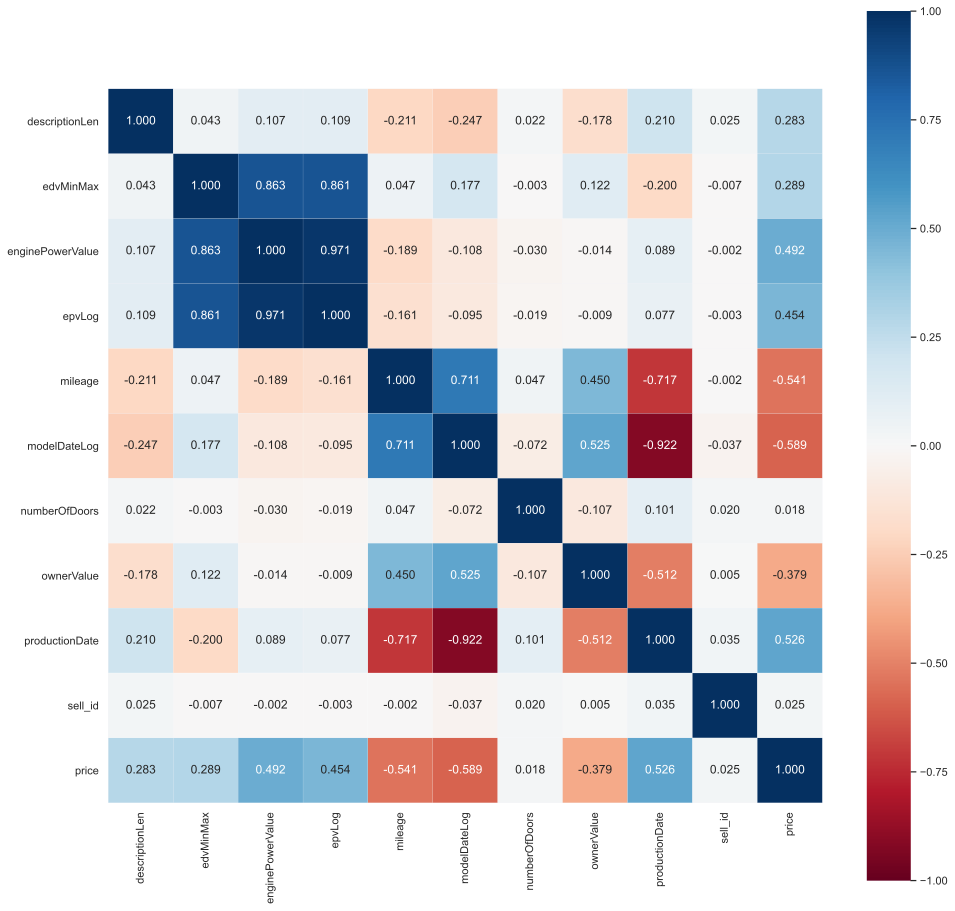

In [20]:
list_to_drop = ['engineDisplacementValue','modelDate','modelDateMM']
heatmap(list_to_drop, data)

In [22]:
list_to_drop = ['engineDisplacementValue','modelDate','modelDateMM',
                'Руль'
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)

Learning rate set to 0.052551
0:	learn: 0.7239374	total: 24.5ms	remaining: 24.5s
1:	learn: 0.6953492	total: 39.4ms	remaining: 19.7s
2:	learn: 0.6672924	total: 53.5ms	remaining: 17.8s
3:	learn: 0.6402560	total: 69.7ms	remaining: 17.3s
4:	learn: 0.6163682	total: 82.4ms	remaining: 16.4s
5:	learn: 0.5934513	total: 96.4ms	remaining: 16s
6:	learn: 0.5708526	total: 108ms	remaining: 15.3s
7:	learn: 0.5490979	total: 114ms	remaining: 14.2s
8:	learn: 0.5286257	total: 121ms	remaining: 13.3s
9:	learn: 0.5099969	total: 129ms	remaining: 12.8s
10:	learn: 0.4912025	total: 135ms	remaining: 12.1s
11:	learn: 0.4742068	total: 150ms	remaining: 12.3s
12:	learn: 0.4580949	total: 161ms	remaining: 12.2s
13:	learn: 0.4431730	total: 172ms	remaining: 12.1s
14:	learn: 0.4282434	total: 178ms	remaining: 11.7s
15:	learn: 0.4152237	total: 188ms	remaining: 11.6s
16:	learn: 0.4013124	total: 195ms	remaining: 11.3s
17:	learn: 0.3892723	total: 202ms	remaining: 11s
18:	learn: 0.3770004	total: 209ms	remaining: 10.8s
19:	learn

In [257]:
data.sample(10)

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,name,numberOfDoors,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль,body,bodyDoors,engineDisplacementValue,edvMinMax,enginePowerValue,modelDateLog,modelDateMM,owners,ownerValue,name1,vehicle
4637,внедорожник 5 дв.,MERCEDES,коричневый,"Автомобилем владею более 2.5 лет, пробег по Но...",3.5 LTR,306 N12,бензин,109000,2011,M_KLASSE,350 3.5 AT (306 л.с.) 4WD,5,1599000.0,2013,1098086106,ALLROAD_5_DOORS AUTOMATIC 3.5,автоматическая,2 владельца,2 года и 9 месяцев,Оригинал,полный,Левый,внедорожник,внедорожник 5,3.5,0.530296,306,2.397895,0.818182,2,2,350 3.5 AT,MERCEDES M_KLASSE ALLROAD_5_DOORS AUTOMATIC 3....
2939,купе,BMW,серебристый,"Авто в хорошем техническом состояние , подвеск...",4.4 LTR,333 N12,бензин,220000,2003,6ER,645i 4.4 AT (333 л.с.),2,550000.0,2003,1099589906,COUPE AUTOMATIC 4.4,автоматическая,3 или более,Не известно,Оригинал,задний,Левый,купе,купе 2,4.4,0.666662,333,2.944439,0.636364,3,3,645i 4.4 AT,BMW 6ER COUPE AUTOMATIC 4.4 645i 4.4 AT
1637,внедорожник 5 дв.,BMW,чёрный,"Камеры 360 градусов,бесключевой доступ,комфорт...",4.4 LTR,407 N12,бензин,109702,2012,X6,50i 4.4 AT (407 л.с.) 4WD,5,1490000.0,2013,1099887006,ALLROAD_5_DOORS AUTOMATIC 4.4,автоматическая,2 владельца,1 год,Оригинал,полный,Левый,внедорожник,внедорожник 5,4.4,0.666662,407,2.302585,0.840909,2,2,50i 4.4 AT,BMW X6 ALLROAD_5_DOORS AUTOMATIC 4.4 50i 4.4 AT
6112,внедорожник 5 дв.,BMW,чёрный,"Ходовая часть полностью новая, сход развал сде...",3.0 LTR,272 N12,бензин,181000,2006,X5,3.0si 3.0 AT (272 л.с.) 4WD,5,750000.0,2008,1094257646,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,3 или более,Не известно,Дубликат,полный,Левый,внедорожник,внедорожник 5,3.0,0.454537,272,2.772589,0.704545,3,3,3.0si 3.0 AT,BMW X5 ALLROAD_5_DOORS AUTOMATIC 3.0 3.0si 3.0...
4903,седан,BMW,серебристый,"В ПТС несколько владельцев. По факту, машина б...",2.0 LTR,150 N12,бензин,122518,2005,3ER,320i 2.0 AT (150 л.с.),4,450000.0,2007,1097499853,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,13 лет и 6 месяцев,Оригинал,задний,Левый,седан,седан 4,2.0,0.303020,150,2.833213,0.681818,3,3,320i 2.0 AT,BMW 3ER SEDAN AUTOMATIC 2.0 320i 2.0 AT
3520,седан,BMW,чёрный,Продаю с двумя комплектами колес 18r 127 стиль...,2.0 LTR,136 N12,бензин,180000,2008,3ER,318i 2.0 AT (136 л.с.),4,500000.0,2011,1090415132,SEDAN AUTOMATIC 2.0,автоматическая,3 или более,3 года,Дубликат,задний,Левый,седан,седан 4,2.0,0.303020,136,2.639057,0.750000,3,3,318i 2.0 AT,BMW 3ER SEDAN AUTOMATIC 2.0 318i 2.0 AT
3905,седан,MERCEDES,синий,"Все документы на руках - оригиналы, в...",1.8 LTR,156 N12,бензин,121155,2011,C_KLASSE,180 BlueEFFICIENCY 1.8 AT (156 л.с.),4,750000.0,2011,1096546706,SEDAN AUTOMATIC 1.8,автоматическая,3 или более,4 года и 3 месяца,Оригинал,задний,Левый,седан,седан 4,1.8,0.272716,156,2.397895,0.818182,3,3,180 BlueEFFICIENCY 1.8 AT,MERCEDES C_KLASSE SEDAN AUTOMATIC 1.8 180 Blue...
3158,внедорожник 5 дв.,MERCEDES,серый,Автомобиль был куплен в январе 2019 года. Спец...,3.0 LTR,249 N12,дизель,23000,2015,GLE_KLASSE_COUPE,350 d 3.0d AT (249 л.с.) 4WD,5,4625000.0,2018,1099949026,ALLROAD_5_DOORS AUTOMATIC 3.0,автоматическая,1 владелец,1 год и 7 месяцев,Оригинал,полный,Левый,внедорожник,внедорожник 5,3.0,0.454537,249,1.945910,0.909091,1,1,350 d 3.0d AT,MERCEDES GLE_KLASSE_COUPE ALLROAD_5_DOORS AUTO...
3995,внедорожник 5 дв.,MERCEDES,серебристый,Автомобиль куплен в Панаввто в 2008 году. ОДИН...,3.5 LTR,272 N12,бензин,210000,2005,M_KLASSE,350 3.5 AT (272 л.с.) 4WD,5,500000.0,2008,1092188100,ALLROAD_5_DOORS AUTOMATIC 3.5,автоматическая,3 или более,12 лет,Оригинал,полный,Левый,внедорожник,внедорожник 5,3.5,0.530296,272,2.833213,0.681818,3,3,350 3.5 AT,MERCEDES M_KLASSE ALLROAD_5_DOORS AUTOMATIC 3....
515,седан,BMW,чёрный,"Владелец девушка, то каждые 10 000 км в специа...",2.0 LTR,156 N12,бензин,250000,2008,3ER,320i 2.0 AT (156 л.с.),4,475000.0,2009,1013774707,SEDAN AUTOMATIC

In [258]:
data['epvLog'] = data.enginePowerValue.apply(np.log)

In [261]:
list_to_drop = ['engineDisplacementValue','modelDate','modelDateMM',
                'Руль',
                'enginePowerValue'
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)

Learning rate set to 0.052551
0:	learn: 0.7221302	total: 3.25ms	remaining: 3.25s
1:	learn: 0.6931279	total: 6.02ms	remaining: 3s
2:	learn: 0.6651156	total: 10.3ms	remaining: 3.42s
3:	learn: 0.6389912	total: 13ms	remaining: 3.23s
4:	learn: 0.6140468	total: 15.7ms	remaining: 3.13s
5:	learn: 0.5900801	total: 18.5ms	remaining: 3.06s
6:	learn: 0.5675087	total: 21.3ms	remaining: 3.02s
7:	learn: 0.5463721	total: 23.9ms	remaining: 2.97s
8:	learn: 0.5263356	total: 26.5ms	remaining: 2.92s
9:	learn: 0.5069309	total: 29.2ms	remaining: 2.89s
10:	learn: 0.4888713	total: 31.9ms	remaining: 2.86s
11:	learn: 0.4718781	total: 34.5ms	remaining: 2.84s
12:	learn: 0.4561076	total: 37.4ms	remaining: 2.84s
13:	learn: 0.4407931	total: 40.8ms	remaining: 2.87s
14:	learn: 0.4263641	total: 43.3ms	remaining: 2.85s
15:	learn: 0.4128552	total: 45.6ms	remaining: 2.8s
16:	learn: 0.4001764	total: 47.9ms	remaining: 2.77s
17:	learn: 0.3879195	total: 50.3ms	remaining: 2.75s
18:	learn: 0.3767579	total: 52.8ms	remaining: 2.73

,vectors0
0,engineDisplacementValue
1,enginePowerValue
2,modelDate
3,modelDateMM
4,Руль


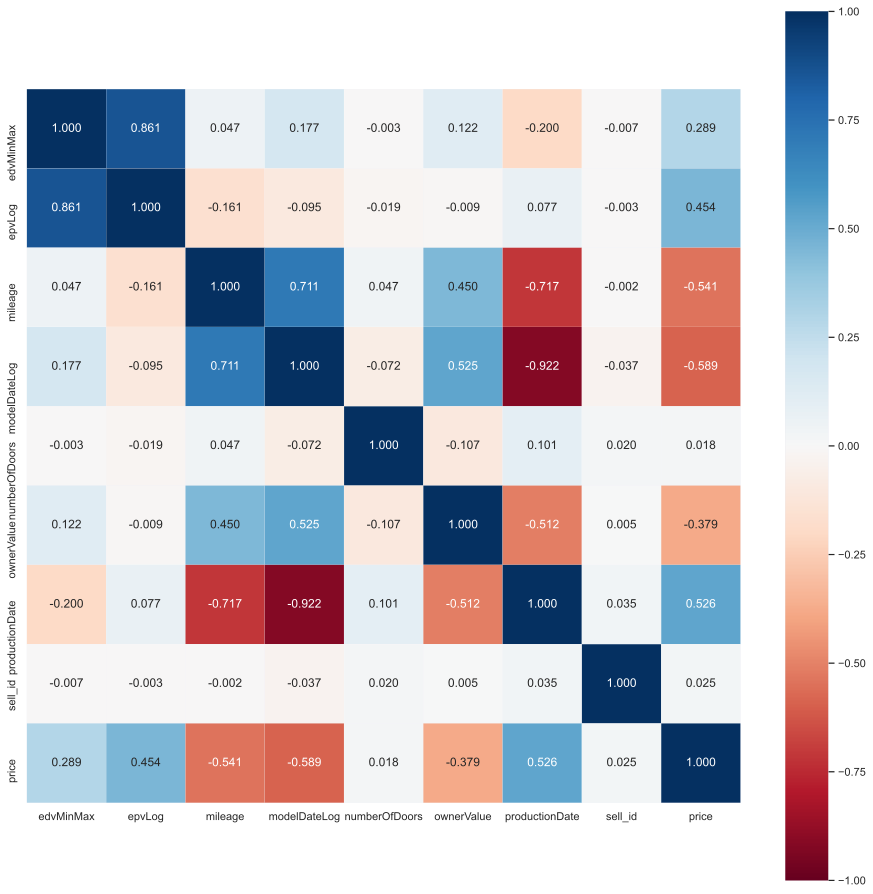

In [262]:
heatmap(list_to_drop, data)

In [293]:
data['descriptionLen'] = data.description.apply(lambda q: len(q.split()))

,vectors0
0,description
1,engineDisplacementValue
2,enginePowerValue
3,modelDate
4,modelDateMM
5,Руль


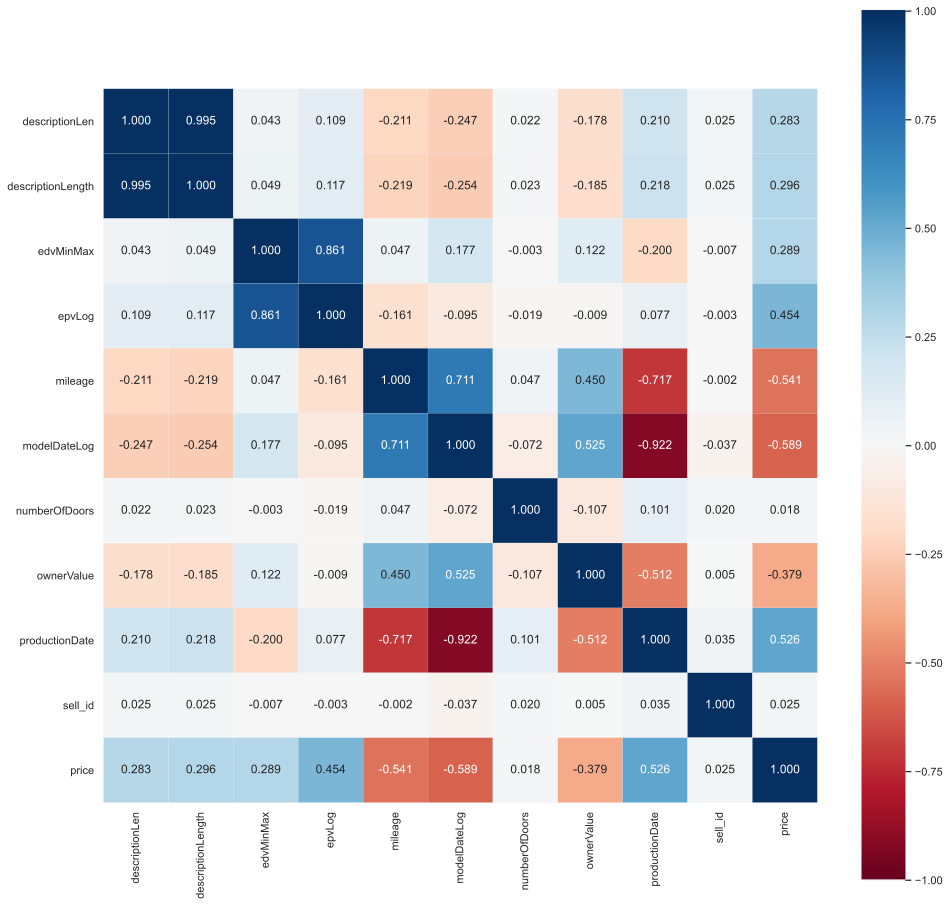

In [316]:
heatmap(list_to_drop, data)

In [23]:
list_to_drop = ['engineDisplacementValue','modelDate','modelDateMM',
                'Руль',
                'enginePowerValue',
                'description',
                ]
parameters = {
    'regressor': CatBoostRegressor(random_state=SEED),
    'encoder': ce.TargetEncoder()
}
feature_imp(data.drop(list_to_drop, axis=1), test_drop=False, **parameters)

Learning rate set to 0.052551
0:	learn: 0.7235693	total: 3ms	remaining: 3s
1:	learn: 0.6938270	total: 5.96ms	remaining: 2.98s
2:	learn: 0.6660611	total: 9.6ms	remaining: 3.19s
3:	learn: 0.6394006	total: 12.3ms	remaining: 3.06s
4:	learn: 0.6145311	total: 14.7ms	remaining: 2.93s
5:	learn: 0.5919762	total: 17.9ms	remaining: 2.97s
6:	learn: 0.5694214	total: 20.5ms	remaining: 2.91s
7:	learn: 0.5493118	total: 23.2ms	remaining: 2.88s
8:	learn: 0.5299482	total: 25.8ms	remaining: 2.84s
9:	learn: 0.5103726	total: 29.2ms	remaining: 2.89s
10:	learn: 0.4927716	total: 32ms	remaining: 2.88s
11:	learn: 0.4751456	total: 34.8ms	remaining: 2.86s
12:	learn: 0.4607073	total: 38.5ms	remaining: 2.92s
13:	learn: 0.4448397	total: 64.6ms	remaining: 4.55s
14:	learn: 0.4299422	total: 70ms	remaining: 4.59s
15:	learn: 0.4156746	total: 77.5ms	remaining: 4.77s
16:	learn: 0.4033791	total: 82.8ms	remaining: 4.79s
17:	learn: 0.3910445	total: 88.3ms	remaining: 4.82s
18:	learn: 0.3801316	total: 93.1ms	remaining: 4.81s
19:

# Submission

In [309]:
x, y = data.drop([TARGET], axis=1), np.log(data[TARGET])
q = test

In [310]:
encoder=ce.TargetEncoder()
encoder.fit(x, y)
x = encoder.transform(x)
q = encoder.transform(q)

In [311]:
model = CatBoostRegressor(iterations = 5000,
                          random_seed = SEED,
                          #eval_metric='MAPE',
                          #custom_metric=['R2', 'MAE'],
                          #silent=True,
                          )
model.fit(x, y,
          #cat_features=cat_features_ids,
          #eval_set=(x, np.log(y_test)),
          verbose_eval=0,
          #use_best_model=True,
          #plot=True
          )

model.save_model('catboost_single_model_EDA1.model')

q['price'] = np.exp(model.predict(q))

In [312]:
sub = q[['sell_id', 'price']]
sub.to_csv('sub.csv', index=False)
sub
# 11.6153% on leaderboard

,sell_id,price
0,1099427284,6.611746e+05
1,1096405886,2.930503e+06
2,1100195294,6.631083e+05
3,1099827282,4.993291e+05
4,1100076198,2.701160e+06
...,...,...
1666,1099414488,1.026984e+06
1667,1099277058,2.560554e+06
1668,1098773964,1.753929e+06
1669,1098835932,1.136438e+06


---
# Clustering befor Regression
---
I have an idea, that before regression better to clustering similar data. Because in life we make just the same way to understand, what price is correct.
For the start I try to use manual clustering per 'brand'.
Second effort - try to clustering items with ML-cluster model K-Means and then make regression machine learning separate in clusters for test items. Two way after: make distance to kmeans-centers as weights to calculate cumulative price, or take prediction only for given cluster for items.

# Manual Clastering

In [334]:
data.groupby(['body'])['sell_id'].count().sort_values(ascending=False)

body
седан                   2833
внедорожник             2313
купе                     424
хэтчбек                  336
лифтбек                  245
универсал                153
минивэн                  146
купе-хардтоп              91
родстер                   60
кабриолет                 43
внедорожник открытый       2
пикап двойная кабина       2
Name: sell_id, dtype: int64

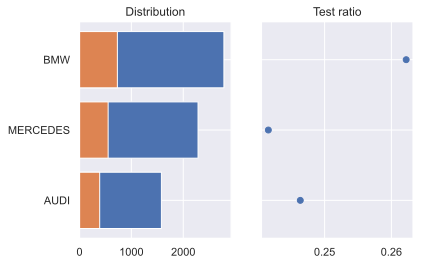

------ Test_set in vector brand has values: -------
{'BMW', 'MERCEDES', 'AUDI'}
------Statistics:  ---------------------------
Data has 3 unique items and has difference:
set(),
--
Test has 3 unique items and has difference:
set().


In [337]:
cat_distribution('brand')

In [354]:
result = pd.DataFrame()

for brand in tqdm(set(data.brand)):
    brand_data = data[data.brand == brand].copy()
    brand_test = test[test.brand == brand].copy()

    x, y = brand_data.drop([TARGET], axis=1), np.log(brand_data[TARGET])
    q = brand_test

    encoder=ce.TargetEncoder()
    encoder.fit(x, y)
    x = encoder.transform(x)
    q = encoder.transform(q)

    model = ExtraTreesRegressor(n_estimators=200, random_state = SEED,)
    model.fit(x, y)

    #model = CatBoostRegressor(iterations = 5000,random_seed = SEED,)
    #model.fit(x, y, verbose_eval=0)

    q['price'] = np.exp(model.predict(q))
    q = q[['sell_id', 'price']]
    result=result.append(q)

  0%|          | 0/3 [00:00<?, ?it/s]

In [355]:
result.to_csv('sub.csv', index=False)
# 12.01 - Catboost
# 12.34 - ExtraTrees

# Regression after Clustering
Идея в том, чтобы кластеризировать объекты и применить регрессию внутри кластеров отдельно в каждом.
Для этого сделаю:
1. Превращаю записи в текст
2. "Токенизирую" текст
3. Векторизирую токены
4. Кластеризирую векторы.

In [70]:
# make list of vectors to tokenization
list_to_token = ['color', 'fuelType', 'mileage', 'model_info', 'productionDate', 'vehicleConfiguration', 'vehicleTransmission', 'body', 'bodyDoors', 'engineDisplacementValue', 'edvMinMax', 'enginePowerValue', 'modelDateLog', 'ownerValue', 'name1', 'vehicle', 'descriptionLen', 'sell_id']

In [104]:
x, y = data[list_to_token], np.log(data[TARGET])
q = test[list_to_token]

In [105]:
# tokenizing dy encoder and standard scaler
encoder=ce.TargetEncoder().fit(x,y)

x = encoder.transform(x)
q = encoder.transform(q)

scaler = StandardScaler().fit(x)
x = scaler.transform(x)
q = scaler.transform(q)

In [397]:
# Создаём объект для выполнения t-SNE
#tsne2 = TSNE(n_components=2, random_state=0)
#tsne3 = TSNE(n_components=3, random_state=0)

# Преобразуем наши данные, понизив размерность с 50 до 2
#x_2 = tsne2.fit_transform(x)
#x_3 = tsne3.fit_transform(x)

In [398]:
#print(np.asarray(x_2).shape)
#print(np.asarray(x_3).shape)

(6648, 3)


### K-Means

In [106]:
kmeans = KMeans(n_clusters=4).fit(x)

In [107]:
# receive clusters for items
y_pred = kmeans.labels_.astype(int)
q_pred = kmeans.predict(q)

data['kmeans']=y_pred
test['kmeans']=q_pred

In [ ]:
# transform data to distance to centers and then transform to wight:
#
q_prob = kmeans.transform(q)
q_prob = (1 - q_prob / q_prob.sum(axis=1)[:,None])/3
q_prob

In [112]:
q_probability = pd.DataFrame(data=q_prob, columns=['cluster1','cluster2', 'cluster3', 'cluster4'])
test = pd.concat([test, q_probability], axis=1)

In [113]:
test.shape, data.shape

((1671, 39), (6648, 36))

In [114]:
# ML regression in clusters

# drop vectors not to encoding
x, y = data.drop([TARGET, 'kmeans'], axis=1), np.log(data[TARGET])
q = test.drop(['kmeans', 'cluster1','cluster2', 'cluster3', 'cluster4'], axis=1).copy()

# encoding cathegorial features
encoder=ce.TargetEncoder().fit(x, y)
x = encoder.transform(x)
q = encoder.transform(q)

# return vectors of kmeans cluster
x['kmeans'] = y_pred
x[TARGET]=y
q['kmeans'] = q_pred

# regression in clusters and save results in new vectors
for cluster in tqdm(set(x.kmeans)):

    cluster_data = x[x.kmeans == cluster].copy()
    cluster_x = cluster_data.drop([TARGET], axis=1)
    cluster_y = cluster_data[TARGET]

    model = CatBoostRegressor(iterations = 5000,random_seed = SEED,)
    model.fit(cluster_x, cluster_y, verbose_eval=0)

    name = f'price_{cluster+1}'
    test[name] = np.exp(model.predict(q))

  0%|          | 0/4 [00:00<?, ?it/s]

In [115]:
test[['price_1', 'price_2', 'price_3', 'price_4']].astype('int64')

,price_1,price_2,price_3,price_4
0,541346,974583,1488472,600147
1,1459144,2799536,2738772,2668557
2,547014,725440,972352,671383
3,464031,595457,1151629,507844
4,1543841,2703183,3575311,1701154
...,...,...,...,...
1666,1170142,962803,1761945,1063240
1667,1175851,2533430,2702891,1690405
1668,1296170,1767161,3505948,1666960
1669,1068678,1168159,1303228,1201645


In [117]:
# first way: make final prediction as sumproduct of weights and cluster regression prices
test['price'] = test.apply(lambda i:
                           (i.price_1 * i.cluster1 +
                           i.price_2 * i.cluster2 +
                            i.price_3 * i.cluster3 +
                           i.price_4 * i.cluster4)//1000*1000,
                           axis=1).astype('int64')

In [122]:
# second way - take only prediction from cluster regression
test['price_kmeans']= test.apply(lambda i:
                                 (i[f'price_{i.kmeans+1}'])//1000*1000
                                 , axis=1).astype('int64')

In [124]:
result = test[['sell_id', 'price_kmeans']]
result.columns=['sell_id', 'price']

In [125]:
result.to_csv('sub.csv', index=False)
# 11.8529 - 3 clusters just # of cluster
# 12.22564 - 4 clusters just # of cluster

# Resume

Unfortunately I can't improve MAPE with method "Clustering before Regression". But I think it is question of time and work to find better way and it can make good predictions